In [1]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import folium 
import branca
from folium import plugins
from folium.plugins import FastMarkerCluster

#### Acquire the street network data

In [3]:
# Put here the coordinates of the centre of the area of analysis
# The point I used for analysis of the Sydney data: 
c_point = (-33.882882592547034, 151.2063073174587)
# For Zurich:
#c_point = (47.372133, 8.516359)
# Change the distance to fit the boundaries of the desired area of analysis

my_area_graph = ox.graph_from_point((c_point[0],c_point[1]),dist=1000)

<Figure size 1440x1440 with 0 Axes>

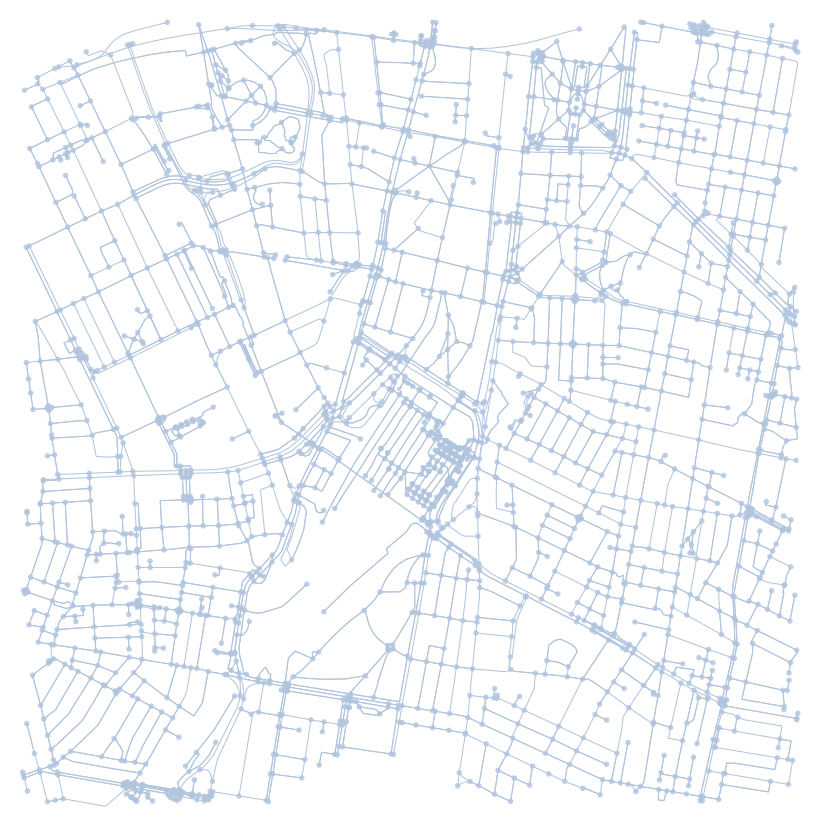

(<Figure size 1080x1080 with 1 Axes>, <AxesSubplot:>)

In [4]:
G = my_area_graph
# Visualise the graph if needed
plt.figure(figsize=(20,20))
ox.plot_graph(my_area_graph, figsize=(15,15),node_color='lightsteelblue',
                           edge_color='lightsteelblue',bgcolor='white',
             node_size=30, node_alpha=0.8)

In [5]:
my_area_dataframe = ox.utils_graph.graph_to_gdfs(G)
#Retrieve and analyse Nodes from the spatial database:
node_csv = my_area_dataframe[0].copy()
#Retrieve and analyse Links from the spatial database:
link_csv = my_area_dataframe[1].copy()


#### Visualise the acquired nodes

In [6]:
nodes_map = folium.Map(location = [c_point[0],c_point[1]], zoom_start = 20, tiles='CartoDB dark_matter' ) 
nodes_map.save("street network nodes_map.html" )

node_latitudes = node_csv['y'].values.tolist()
node_longitudes = node_csv['x'].values.tolist()

northwest_mark = (node_csv['y'].max(),node_csv['x'].min())
northeast_mark = (node_csv['y'].max(), node_csv['x'].max())
southwest_mark = (node_csv['y'].min(), node_csv['x'].min())
southeast_mark = (node_csv['y'].min(), node_csv['x'].max())




folium.CircleMarker([northwest_mark[0],northwest_mark[1]], color='red', fill=True, radius=20, opacity=1,
               popup = 'northwest').add_to(nodes_map)
folium.CircleMarker([northeast_mark[0],northeast_mark[1]], color='red', fill=True, radius=20, opacity=1,
               popup = 'northwest').add_to(nodes_map)
folium.CircleMarker([southwest_mark[0],southwest_mark[1]], color='red', fill=True, radius=20, opacity=1,
               popup = 'northwest').add_to(nodes_map)
folium.CircleMarker([southeast_mark[0],southeast_mark[1]], color='red', fill=True, radius=20, opacity=1,
               popup = 'northwest').add_to(nodes_map)

for item in list(zip(node_latitudes,node_longitudes)):
    folium.CircleMarker([item[0],item[1]], color='red', fill=True, radius=0.2, opacity=1,
               popup = 'node').add_to(nodes_map)
    
nodes_map.save("street network nodes_map.html" )
from IPython.display import IFrame

IFrame(src='./street network nodes_map.html', width=1500, height=1500)

#### Create lists to store tags associated with different traffic levels

In [7]:
street_types=[]

for i in link_csv.index:
    if link_csv.loc[i,'highway'] not in street_types:
        street_types.append(link_csv.loc[i,'highway'])


# make a new column that has the 'highway' values as string
# (because this is easier to evaluate in comparison to tuples)
link_csv['highway_copy'] = link_csv['highway'].astype(str)




#Definitions from OpenStreetMap:
#footway:'mapping minor pathways which are used mainly or exclusively by pedestrians'

#path:'highway=path is a generic path, either multi-use or unspecified usage, open to all non-motorized vehicles 
#and not intended for motorized vehicles unless tagged so separately. The path may have any type of surface.'

#residential:'The tag highway=residential is used on roads that are used for accessing residential areas and in residential areas but which are not normally 
#used as through routes (which would usually be unclassified highways, tertiary highways, etc.)'

#living_street:'The highway=living_street tag is used to tag living streets or other implementations of shared space. These type of roads have lower speed limits, 
#and special traffic and parking rules compared to streets tagged using residential)'



# Tags associated with different levels of traffic:
# Level 4 (Highest)
super_high_traffic = 'motorway', 'motorway_link', 'trunk', 'trunk_link'
# Level 3 (2nd highest)
high_traffic = 'primary', 'primary_link'
# Level 2 
medium_traffic = 'secondary', 'secondary_link'
# Level 1
low_traffic = 'tertiary', 'tertiary_link'




#### assign traffic levels derived from parsing the 'highway' column

In [8]:

link_csv['traffic']=0

for item in street_types:
    sub_df = link_csv[link_csv['highway_copy']==str(item)]
    # For streets that have only 1 tag associated with traffic:
    if isinstance(item, list)==False:
        if item in low_traffic:            
            link_csv.loc[sub_df.index, 'traffic']=1
        if item in medium_traffic:
            link_csv.loc[sub_df.index, 'traffic']=2
        if item in high_traffic:
            link_csv.loc[sub_df.index, 'traffic']=3
        if item in super_high_traffic:
            link_csv.loc[sub_df.index, 'traffic']=4
    else:   
        # For streets that have more than 1 tag associated with traffic:
        this_low_traffic,this_med_traffic,this_high_traffic,this_super_high_traffic=0,0,0,0
        for it in item:
            if it in low_traffic:
                this_low_traffic+=1
            if it in medium_traffic:
                this_med_traffic+=2
            if it in high_traffic:
                this_high_traffic +=3
            if it in super_high_traffic:
                this_super_high_traffic +=4
        traffic_num = max([this_low_traffic,this_med_traffic,this_high_traffic,this_super_high_traffic])
        link_csv.loc[sub_df.index, 'traffic']=traffic_num
     
 
    
link_csv = link_csv.drop(columns='highway_copy')
link_csv['traffic']=link_csv['traffic'].fillna(0)

#### visualize high traffic nodes if needed

In [9]:
high_traffic_nodes = link_csv[link_csv['traffic']>=2]['u'].values.tolist()

my_map2 = folium.Map(location = [c_point[0],c_point[1]], zoom_start = 20, tiles='CartoDB dark_matter' ) 
my_map2.save("high_traffic_nodes.html" )

high_traffic_nodes_lat= node_csv.loc[high_traffic_nodes, 'y'].values.tolist()
high_traffic_nodes_lon= node_csv.loc[high_traffic_nodes, 'x'].values.tolist()

for item in list(zip(high_traffic_nodes_lat,high_traffic_nodes_lon)):
    folium.CircleMarker([item[0],item[1]], color='red', fill=True, radius=0.5, opacity=1,
               popup = 'node').add_to(my_map2)

    
my_map2.save("high_traffic_nodes.html" )
from IPython.display import IFrame

IFrame(src='./high_traffic_nodes.html', width=1500, height=1500)

#### delete some unneccessary columns

In [10]:
if 'access' in link_csv.columns:
    link_csv = link_csv.drop(columns='access')
if 'highway' in link_csv.columns:
    link_csv = link_csv.drop(columns='highway')
if 'key' in link_csv.columns:
    link_csv = link_csv.drop(columns='key')
if 'ref' in link_csv.columns:
    link_csv = link_csv.drop(columns='ref')

In [11]:
#Save this file to a folder that has all the files related to the spatial database 
link_csv.to_csv(r'C:\Users\demdr\Desktop\Testing the thesis functions\Project data\Spatial database\Urban network analysis_links.csv')
node_csv.to_csv(r'C:\Users\demdr\Desktop\Testing the thesis functions\Project data\Spatial database\Urban network analysis_nodes.csv')
